In [4]:
import argparse
import os
import sys
import time
import math
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
import h5py
import random
from copy import copy
from datetime import datetime
import tqdm

def Diff_mat_1D(Nx, device='cpu'):
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx))
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  

    D2_1d = sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx))
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  
    

    return D_1d, D2_1d


def burgers_numeric_solve_free(u0, f, visc, T, dt=1e-4, num_t=10, mode=None):
    if mode!='const':
        raise ValueError

    s = u0.size(-1)
    Nt = f.size(1)

    Nu0 = u0.size(0)
    Nf = f.size(0)
    N = Nf
     
    xmin = 0.0; xmax = 1.0
    delta_x = (xmax-xmin)/(s+1)

    steps = math.ceil(T/dt)

    u = u0.reshape(N, s)
    u = F.pad(u, (1,1))
    f = f.reshape(N, Nt, s)
    f = F.pad(f, (1,1))
    
    record_time = math.floor(steps / Nt)
    
    D_1d, D2_1d = Diff_mat_1D(s + 2, device=u0.device)
    D_1d.rows[0] = D_1d.rows[0][:2]
    D_1d.rows[-1] = D_1d.rows[-1][-2:]
    D_1d.data[0] = D_1d.data[0][:2]
    D_1d.data[-1] = D_1d.data[-1][-2:]
    
    D2_1d.rows[0] = D2_1d.rows[0][:3]
    D2_1d.rows[-1] = D2_1d.rows[-1][-3:]
    D2_1d.data[0] = D2_1d.data[0][:3]
    D2_1d.data[-1] = D2_1d.data[-1][-3:]
    
    t_sys_ind = list(D_1d.rows)
    t_sys = torch.FloatTensor(np.stack(D_1d.data)/(2*delta_x)).to(u0.device)
    d_sys_ind = list(D2_1d.rows)
    d_sys = torch.FloatTensor(visc*np.stack(D2_1d.data)/delta_x**2).to(u0.device)
    
    sol = torch.zeros(N, s, Nt, device=u0.device)
    
    c = 0
    t = 0.0
    f_idx = -1
    for j in tqdm.trange(steps):
        u = u[...,1:-1]
        u = F.pad(u, (1,1))
        
        u_s = u**2
        transport = torch.einsum('nsi,si->ns', u_s[...,t_sys_ind], t_sys)
        diffusion = torch.einsum('nsi,si->ns', u[...,d_sys_ind], d_sys)
        if j % record_time == 0:
            f_idx += 1
        u = u + dt * (-(1 / 2) * transport + diffusion + f[:, f_idx, :])
        
        t += dt

        if (j+1) % record_time == 0:

            sol[...,c] = u[...,1:-1]
            c += 1

    sol = sol.permute(0, 2, 1)
    trajectory = torch.cat((u0.reshape(N, 1, s), sol), dim=1)
    return trajectory

def generate_initial_y(x):
    r"""
    Generate the initial state u(0, x) as a superposition of two Gaussian functions.
    """
    # Sampling parameters for the Gaussian functions
    a1 = np.random.uniform(0, 2)
    a2 = np.random.uniform(-2, 0)
    mu1 = np.random.uniform(0.2, 0.4)
    mu2 = np.random.uniform(0.6, 0.8)
    sigma1 = np.random.uniform(0.05, 0.15)
    sigma2 = np.random.uniform(0.05, 0.15)
    
    y = a1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2)) +\
        a2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    y[0] = 0 # Apply 0 boundary condition
    y[-1] = 0 # Apply 0 boundary condition
    return y

torch.Size([128])

In [10]:
x=np.linspace(0,1,128)

u0=generate_initial_y(x)
u0=torch.tensor(u0).float()
f=torch.zeros(10000,128)
trajectory = burgers_numeric_solve_free(
                u0, f, visc=0.01, T=1, dt=1e-4, 
                num_t=10000,
                mode='const'
            )

RuntimeError: shape '[10000, 128]' is invalid for input of size 128

In [11]:
import argparse
import os
import sys
import time
import math
import numpy as np
import torch
import torch.nn.functional as F
import scipy.sparse as sp
import h5py
import random
from copy import copy
from datetime import datetime
import tqdm


class burgers():
    def __init__(self,
                 tmin: float=None,
                 tmax: float=None,
                 grid_size: list=None,
                 L: float=None,
                 flux_splitting: str=None,
                 device: torch.cuda.device = "cpu") -> None:
        super().__init__()
        self.tmin = 0 if tmin is None else tmin
        self.tmax = 1 if tmax is None else tmax
        self.L = 1 if L is None else L
        self.grid_size = (11, 128) if grid_size is None else grid_size
        self.dt = self.tmax / (self.grid_size[0]-1)
        self.dx = self.L / (self.grid_size[1]+1)
        self.device = device
        self.force = None

    def __repr__(self):
        return f'burgers'


def check_files(pde: dict, modes: dict, experiment: str) -> None:
    for mode, replace, num_samples in modes:
        save_name = "data/" + "_".join([str(pde[list(pde.keys())[0]]), mode])
        if (replace == True):
            if os.path.exists(f'{save_name}.h5'):
                os.remove(f'{save_name}.h5')
            else:
                pass
        else:
            pass


def check_directory() -> None:
    if os.path.exists(f'data'):
        pass
    else:
        os.mkdir(f'data')
    if not os.path.exists(f'data/log'):
        os.mkdir(f'data/log')


def Diff_mat_1D(Nx, device='cpu'):
    D_1d = sp.diags([-1, 1], [-1, 1], shape = (Nx,Nx))
    D_1d = sp.lil_matrix(D_1d)
    D_1d[0,[0,1,2]] = [-3, 4, -1]               
    D_1d[Nx-1,[Nx-3, Nx-2, Nx-1]] = [1, -4, 3]  

    D2_1d = sp.diags([1, -2, 1], [-1,0,1], shape = (Nx, Nx))
    D2_1d = sp.lil_matrix(D2_1d)                  
    D2_1d[0,[0,1,2,3]] = [2, -5, 4, -1]                    
    D2_1d[Nx-1,[Nx-4, Nx-3, Nx-2, Nx-1]] = [-1, 4, -5, 2]  
    

    return D_1d, D2_1d


def burgers_numeric_solve(u0, f, visc, T, dt=1e-4, num_t=10, mode=None):
    if mode!='const':
        f=f.unsqueeze(1).repeat(1,num_t,1)
    
    s = u0.size(-1)
    
    Nu0 = u0.size(0)
    Nf = f.size(0)
    Nt = f.size(1)
    
    xmin = 0.0; xmax = 1.0
    delta_x = (xmax-xmin)/(s+1)

    steps = math.ceil(T/dt)

    u = u0.reshape(Nu0,1,s)
    u = F.pad(u, (1,1))
    f = f.reshape(1,Nf,Nt,s)
    f = F.pad(f, (1,1))
    
    record_time = math.floor(steps / Nt)
    
    D_1d, D2_1d = Diff_mat_1D(s + 2, device=u0.device)
    D_1d.rows[0] = D_1d.rows[0][:2]
    D_1d.rows[-1] = D_1d.rows[-1][-2:]
    D_1d.data[0] = D_1d.data[0][:2]
    D_1d.data[-1] = D_1d.data[-1][-2:]
    
    D2_1d.rows[0] = D2_1d.rows[0][:3]
    D2_1d.rows[-1] = D2_1d.rows[-1][-3:]
    D2_1d.data[0] = D2_1d.data[0][:3]
    D2_1d.data[-1] = D2_1d.data[-1][-3:]
    
    t_sys_ind = list(D_1d.rows)
    t_sys = torch.FloatTensor(np.stack(D_1d.data)/(2*delta_x)).to(u0.device)
    d_sys_ind = list(D2_1d.rows)
    d_sys = torch.FloatTensor(visc*np.stack(D2_1d.data)/delta_x**2).to(u0.device)
    
    sol = torch.zeros(Nu0, Nf, s, Nt, device=u0.device)
    
    c = 0
    t = 0.0
    f_idx = -1
    for j in range(steps):
        u = u[...,1:-1]
        u = F.pad(u, (1,1))
        
        u_s = u**2
        transport = torch.einsum('bcsi,si->bcs', u_s[...,t_sys_ind], t_sys)
        diffusion = torch.einsum('bcsi,si->bcs', u[...,d_sys_ind], d_sys)
        if j % record_time == 0:
            f_idx += 1
        u = u + dt * (-(1 / 2) * transport + diffusion + f[:,:,f_idx,:])
        
        t += dt

        if (j+1) % record_time == 0:

            sol[...,c] = u[...,1:-1]
            c += 1

    sol = sol.permute(0,1,3,2)
    trajectory = torch.cat((u0.reshape(Nu0,1,1,s).repeat(1,Nf,1,1), sol),dim=2)
    return trajectory

def burgers_numeric_solve_free(u0, f, visc, T, dt=1e-4, num_t=10, mode=None):
    if mode!='const':
        raise ValueError

    s = u0.size(-1)
    Nt = f.size(1)

    Nu0 = u0.size(0)
    Nf = f.size(0)
    N = Nf
     
    xmin = 0.0; xmax = 1.0
    delta_x = (xmax-xmin)/(s+1)

    steps = math.ceil(T/dt)

    u = u0.reshape(N, s)
    u = F.pad(u, (1,1))
    f = f.reshape(N, Nt, s)
    f = F.pad(f, (1,1))
    
    record_time = math.floor(steps / Nt)
    
    D_1d, D2_1d = Diff_mat_1D(s + 2, device=u0.device)
    D_1d.rows[0] = D_1d.rows[0][:2]
    D_1d.rows[-1] = D_1d.rows[-1][-2:]
    D_1d.data[0] = D_1d.data[0][:2]
    D_1d.data[-1] = D_1d.data[-1][-2:]
    
    D2_1d.rows[0] = D2_1d.rows[0][:3]
    D2_1d.rows[-1] = D2_1d.rows[-1][-3:]
    D2_1d.data[0] = D2_1d.data[0][:3]
    D2_1d.data[-1] = D2_1d.data[-1][-3:]
    
    t_sys_ind = list(D_1d.rows)
    t_sys = torch.FloatTensor(np.stack(D_1d.data)/(2*delta_x)).to(u0.device)
    d_sys_ind = list(D2_1d.rows)
    d_sys = torch.FloatTensor(visc*np.stack(D2_1d.data)/delta_x**2).to(u0.device)
    
    sol = torch.zeros(N, s, Nt, device=u0.device)
    
    c = 0
    t = 0.0
    f_idx = -1
    for j in tqdm.trange(steps):
        u = u[...,1:-1]
        u = F.pad(u, (1,1))
        
        u_s = u**2
        transport = torch.einsum('nsi,si->ns', u_s[...,t_sys_ind], t_sys)
        diffusion = torch.einsum('nsi,si->ns', u[...,d_sys_ind], d_sys)
        if j % record_time == 0:
            f_idx += 1
        u = u + dt * (-(1 / 2) * transport + diffusion + f[:, f_idx, :])
        
        t += dt

        if (j+1) % record_time == 0:

            sol[...,c] = u[...,1:-1]
            c += 1

    sol = sol.permute(0, 2, 1)
    trajectory = torch.cat((u0.reshape(N, 1, s), sol), dim=1)
    return trajectory


def make_data(Nu0, Nf, s):
    xmin = 0.0; xmax = 1.0
    delta_x = (xmax-xmin)/(s+1)
    x = torch.linspace(xmin+delta_x,xmax-delta_x,s)
    
    loc1 = np.random.uniform(0.2, 0.4, (Nu0,1))
    amp1 = np.random.uniform(0, 2, (Nu0,1))
    sig1 = np.random.uniform(0.05, 0.15, (Nu0,1))
    gauss1=amp1*np.exp(-0.5*(np.array(x.view(1,-1).repeat(Nu0,1))-loc1)**2/sig1**2)

    loc2 = np.random.uniform(0.6, 0.8, (Nu0,1))
    amp2 = np.random.uniform(-2, 0, (Nu0,1))
    sig2 = np.random.uniform(0.05, 0.15, (Nu0,1))
    gauss2=amp2*np.exp(-0.5*(np.array(x.view(1,-1).repeat(Nu0,1))-loc2)**2/sig2**2)

    u0=gauss1+gauss2
    
    def rand_f(is_rand_amp=True):
        loc = np.random.uniform(0, 1, (Nf,1))
        if is_rand_amp:
            amp = np.random.randint(2, size=(Nf,1)) * np.random.uniform(-1.5, 1.5, (Nf,1))
        else:
            amp = np.random.uniform(-1.5, 1.5, (Nf,1))
        sig = np.random.uniform(0.1, 0.4, (Nf,1))*0.5
        return amp*np.exp(-0.5*(np.array(x.view(1,-1).repeat(Nf,1))-loc)**2/sig**2)
    sum_num_f=7
    f=rand_f(is_rand_amp=False)
    for i in range(sum_num_f):
        f+=rand_f(is_rand_amp=True)

    return u0, f

def make_data_varying_f(Nu0, Nf, s, t, amp_compensate=2, partial_control=None):
    xmin = 0.0; xmax = 1.0
    delta_x = (xmax-xmin)/(s+1)
    x = torch.linspace(xmin+delta_x,xmax-delta_x,s)

    tmin = 0.0; tmax = 1.0
    delta_t = (tmax-tmin)/(t+1)
    ts = torch.linspace(tmin+delta_t,tmax-delta_t,t)
    
    loc1 = np.random.uniform(0.2, 0.4, (Nu0,1))
    amp1 = np.random.uniform(0, 2, (Nu0,1))
    sig1 = np.random.uniform(0.05, 0.15, (Nu0,1))
    gauss1=amp1*np.exp(-0.5*(np.array(x.view(1,-1).repeat(Nu0,1))-loc1)**2/sig1**2)

    loc2 = np.random.uniform(0.6, 0.8, (Nu0,1))
    amp2 = np.random.uniform(-2, 0, (Nu0,1))
    sig2 = np.random.uniform(0.05, 0.15, (Nu0,1))
    gauss2=amp2*np.exp(-0.5*(np.array(x.view(1,-1).repeat(Nu0,1))-loc2)**2/sig2**2)

    u0=gauss1+gauss2
    
    if partial_control is None:
        f_space_mask = np.ones_like(x.view(1, 1, -1).repeat(Nf, t, 1))
    elif partial_control == 'front_rear_quarter':
        f_space_mask = np.zeros_like(x.view(1, 1, -1).repeat(Nf, t, 1))
        controllable_idx = np.hstack((
            np.arange(0, s // 4), 
            np.arange(3 * s // 4, s)
        ))
        f_space_mask[:, :, controllable_idx] = 1.
        amp_compensate *= 2
    else:
        raise ValueError('invalid partial control mode')

    def rand_f(is_rand_amp=True):
        if is_rand_amp:
            amp = np.random.randint(2, size=(Nf, 1, 1)) * np.random.uniform(-1.5, 1.5, (Nf, 1, 1))
        else:
            amp = np.random.uniform(-1.5, 1.5, (Nf, 1, 1))
        amp = torch.tensor(amp).repeat(1, t, s)

        loc = np.random.uniform(0, 1, (Nf, 1, 1))
        sig = np.random.uniform(0.1, 0.4, (Nf, 1, 1))*0.5
        exp_space = np.exp(-0.5*(np.array(x.view(1, 1, -1).repeat(Nf, t, 1))-loc)**2/sig**2)
        exp_space = exp_space * f_space_mask

        loc = np.random.uniform(0, 1, (Nf, 1, 1))
        sig = np.random.uniform(0.1, 0.4, (Nf, 1, 1)) * 0.5
        exp_time = amp_compensate * \
            np.exp(-0.5*(np.array(ts.view(1, -1, 1).repeat(Nf, 1, s))-loc)**2/sig**2)
        return amp * exp_space * exp_time
    
    sum_num_f=7
    f=rand_f(is_rand_amp=False)
    for i in range(sum_num_f):
        f+=rand_f(is_rand_amp=True)
    f = f.to(torch.float32)

    return u0, f

In [14]:
x=np.linspace(0,1,128)

u0=generate_initial_y(x).reshape(1,128,1)
u0=torch.tensor(u0).float()
f=torch.zeros(1,10000,128)
trajectory = burgers_numeric_solve_free(
                u0, f, visc=0.01, T=1, dt=1e-4, 
                num_t=10000,
                mode='const'
            )

RuntimeError: shape '[1, 1]' is invalid for input of size 128

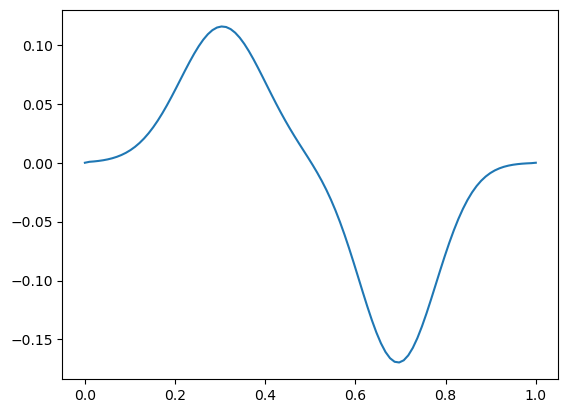

In [16]:
def generate_initial_y(x):
    r"""
    Generate the initial state u(0, x) as a superposition of two Gaussian functions.
    """
    # Sampling parameters for the Gaussian functions
    a1 = np.random.uniform(0, 2)
    a2 = np.random.uniform(-2, 0)
    mu1 = np.random.uniform(0.2, 0.4)
    mu2 = np.random.uniform(0.6, 0.8)
    sigma1 = np.random.uniform(0.05, 0.15)
    sigma2 = np.random.uniform(0.05, 0.15)
    
    y = a1 * np.exp(-((x - mu1)**2) / (2 * sigma1**2)) +\
        a2 * np.exp(-((x - mu2)**2) / (2 * sigma2**2))
    y[0] = 0 # Apply 0 boundary condition
    y[-1] = 0 # Apply 0 boundary condition
    return y
y=generate_initial_y(np.linspace(0,1,100))
import matplotlib.pyplot as plt
plt.plot(np.linspace(0,1,100),y)
plt.show()

C:\Users\24021\AppData\Local\Temp\ipykernel_21564\2596897983.py:26: RuntimeWarning: overflow encountered in multiply
  u = u - dt * u * du_dx + nu * dt * d2u_dx2
d:\Anaconda3\envs\env_py312\Lib\site-packages\numpy\lib\function_base.py:1238: RuntimeWarning: invalid value encountered in subtract
  out[tuple(slice1)] = (f[tuple(slice4)] - f[tuple(slice2)]) / (2. * ax_dx)
C:\Users\24021\AppData\Local\Temp\ipykernel_21564\2596897983.py:26: RuntimeWarning: invalid value encountered in subtract
  u = u - dt * u * du_dx + nu * dt * d2u_dx2
C:\Users\24021\AppData\Local\Temp\ipykernel_21564\2596897983.py:26: RuntimeWarning: invalid value encountered in add
  u = u - dt * u * du_dx + nu * dt * d2u_dx2


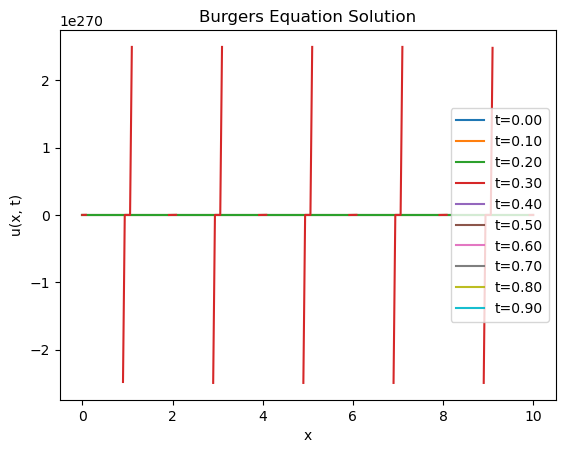

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# 参数设置
L = 10.0  # 空间长度
T = 1.0   # 计算时间
Nx = 256  # 空间网格数
Nt = 500  # 时间步数
dx = L / Nx  # 空间步长
dt = T / Nt  # 时间步长
nu = 0.01  # 粘度

# 初始化网格
x = np.linspace(0, L, Nx)
u = np.sin(2 * np.pi * x)  # 初始条件：正弦波

# 计算Burgers方程的数值解
for n in range(Nt):
    # 使用WENO方法计算空间导数
    # 计算一阶导数（u * du/dx）
    du_dx = np.gradient(u, dx)  # 计算一阶导数
    # 计算二阶导数（du/dx的导数）
    d2u_dx2 = np.gradient(du_dx, dx)  # 计算二阶导数

    # 更新u的值，Euler方法
    u = u - dt * u * du_dx + nu * dt * d2u_dx2
    
    # 记录或输出计算结果
    if n % 50 == 0:
        plt.plot(x, u, label=f't={n*dt:.2f}')

# 绘制结果
plt.title('Burgers Equation Solution')
plt.xlabel('x')
plt.ylabel('u(x, t)')
plt.legend()
plt.show()
